This notebook will run PCA and NMF, fit on varying numbers of components. Each of these PCA/NMF runs will serve as dimension reduced features that will be fed into a SVM. We compare the results of each of these models with a baseline model trained on raw data. 

This task is repeated on three different Eigenface classification tasks (glasses vs. no glasses, head positions, and emotions). 

In [91]:
# Libraries 
import pandas as pd 
import numpy as np 

import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms

import sys

sys.path.append("../python")

import matplotlib.pyplot as plt
from preprocess_data import EigenfacesDataset

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.decomposition import PCA



In [60]:
# Load the different datasets
normalize_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])

eye_state_dataset = EigenfacesDataset(
    data_dir='../data',
    label='eye_state',
    transform=normalize_transform)
eye_state_dataloader = DataLoader(eye_state_dataset)

head_position_dataset = EigenfacesDataset(
    data_dir='../data',
    label='head_position',
    transform=normalize_transform)
head_position_dataloader = DataLoader(head_position_dataset)


facial_expression_dataset = EigenfacesDataset(
    data_dir='../data',
    label='facial_expression',
    transform=normalize_transform)
facial_expression_dataloader = DataLoader(facial_expression_dataset)


In [34]:
# Helper function for grabbing labels 
def grab_labels(dataset): 
    labels = [] 
    for i in range(len(dataset)):
        _, label_idx = dataset[i]
        label = dataset.classes[label_idx]
        labels.append(label)
    return labels

In [63]:
# Helper function for flattening the datasets for model training
def grab_data(dataloader):
    flat_tensors = []
    for tensor_list in dataloader:
        flattened_tensors = torch.flatten(tensor_list[0].squeeze())
        flat_tensors.append(flattened_tensors)
    result_tensor = torch.stack(flat_tensors, dim=0)
    return result_tensor

In [65]:
# Grab the labels for each classification task
eye_states = grab_labels(eye_state_dataset)
head_positions = grab_labels(head_position_dataset)
facial_expressions = grab_labels(facial_expression_dataset)

# Grab the data
eye_state_imgs = grab_data(eye_state_dataloader)
head_position_imgs = grab_data(head_position_dataloader)
facial_expression_imgs = grab_data(facial_expression_dataloader)

In [67]:
# Inspect data sizes
print(eye_state_imgs.shape)
print(head_position_imgs.shape)
print(facial_expression_imgs.shape)

torch.Size([624, 15360])
torch.Size([624, 15360])
torch.Size([624, 15360])


## BASELINE MODELS

In [73]:
# Train/test split
# TODO: eventually I think instead of random split we should hold out all images from certain individuals
eye_X_train, eye_X_test, eye_y_train, eye_y_test = train_test_split(eye_state_imgs, eye_states, test_size=0.2, random_state=315)
head_X_train, head_X_test, head_y_train, head_y_test = train_test_split(head_position_imgs, head_positions, test_size=0.2, random_state=315)
facial_X_train, facial_X_test, facial_y_train, facial_y_test = train_test_split(facial_expression_imgs, facial_expressions, test_size=0.2, random_state=315)

In [118]:
def SVM_metrics(X_train, X_test, y_train, y_test):
    clf = svm.SVC()
    clf.fit(X_train, y_train)

    y_train_hat = clf.predict(X_train)
    y_test_hat = clf.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_train_hat)
    test_accuracy = accuracy_score(y_test, y_test_hat)

    train_cm = confusion_matrix(y_train, y_train_hat)
    test_cm = confusion_matrix(y_test, y_test_hat)

    return train_accuracy, test_accuracy, train_cm, test_cm


In [119]:
# Train baseline SVMs on each of the datasets
eye_train_accuracy, eye_test_accuracy, eye_train_cm, eye_test_cm = SVM_metrics(eye_X_train, eye_X_test, eye_y_train, eye_y_test)
head_train_accuracy, head_test_accuracy, head_train_cm, head_test_cm = SVM_metrics(head_X_train, head_X_test, head_y_train, head_y_test)
facial_train_accuracy, facial_test_accuracy, facial_train_cm, facial_test_cm = SVM_metrics(facial_X_train, facial_X_test, facial_y_train, facial_y_test)

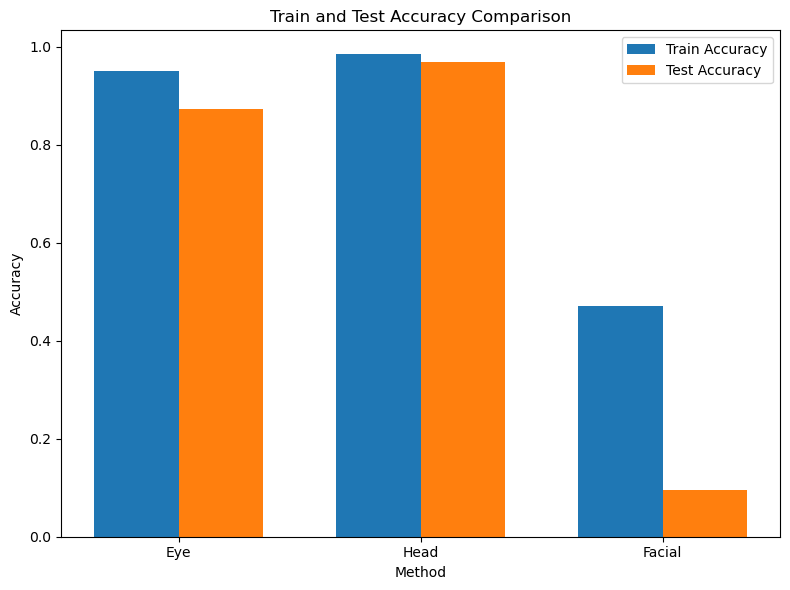

In [121]:
import numpy as np
import matplotlib.pyplot as plt

# Accuracy values for each method
train_accuracies = [eye_train_accuracy, head_train_accuracy, facial_train_accuracy]
test_accuracies = [eye_test_accuracy, head_test_accuracy, facial_test_accuracy]

# Method labels
methods = ['Eye', 'Head', 'Facial']

# Plotting the bar plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as per your preference

bar_width = 0.35
index = np.arange(len(methods))

plt.bar(index, train_accuracies, bar_width, label='Train Accuracy')
plt.bar(index + bar_width, test_accuracies, bar_width, label='Test Accuracy')

plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy Comparison')
plt.xticks(index + bar_width/2, methods)
plt.legend()
plt.tight_layout()
plt.show()


## PCA MODELS

In [123]:
# Helper function to run PCA and return dimension reduced data
def fit_PCA(X_train, X_test, n_component):
    X_train = X_train.numpy()
    X_test = X_test.numpy()

    pca = PCA(n_components=n_component)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    return X_train_pca, X_test_pca

# Helper function to run SVM on a variety of n_component configurations
def test_PCA_components(X_train, X_test, y_train, y_test, n_component):
    new_X_train, new_X_test = fit_PCA(X_train, X_test, n_component)
    train_accuracy, test_accuracy, train_cm, test_cm = SVM_metrics(new_X_train, new_X_test, y_train, y_test)

    return train_accuracy, test_accuracy, train_cm, test_cm


In [124]:
n_components = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

eye_train_pca_accuracies = []
eye_train_pca_cms = []
eye_test_pca_accuracies = []
eye_test_pca_cms = []

head_train_pca_accuracies = []
head_train_pca_cms = []
head_test_pca_accuracies = []
head_test_pca_cms = []

facial_train_pca_accuracies = []
facial_train_pca_cms = []
facial_test_pca_accuracies = []
facial_test_pca_cms = []

for n in n_components: 
    eye_train_accuracy, eye_test_accuracy, eye_train_cm, eye_test_cm = test_PCA_components(eye_X_train, eye_X_test, eye_y_train, eye_y_test, n)
    eye_train_pca_accuracies.append(eye_train_accuracy)
    eye_train_pca_cms.append(eye_train_cm)
    eye_test_pca_accuracies.append(eye_test_accuracy)
    eye_test_pca_cms.append(eye_test_cm)

    head_train_accuracy, head_test_accuracy, head_train_cm, head_test_cm = test_PCA_components(head_X_train, head_X_test, head_y_train, head_y_test, n)
    head_train_pca_accuracies.append(head_train_accuracy)
    head_train_pca_cms.append(head_train_cm)
    head_test_pca_accuracies.append(head_test_accuracy)
    head_test_pca_cms.append(head_test_cm)

    facial_train_accuracy, facial_test_accuracy, facial_train_cm, facial_test_cm = test_PCA_components(facial_X_train, facial_X_test, facial_y_train, facial_y_test, n)
    facial_train_pca_accuracies.append(facial_train_accuracy)
    facial_train_pca_cms.append(facial_train_cm)
    facial_test_pca_accuracies.append(facial_test_accuracy)
    facial_test_pca_cms.append(facial_test_cm)


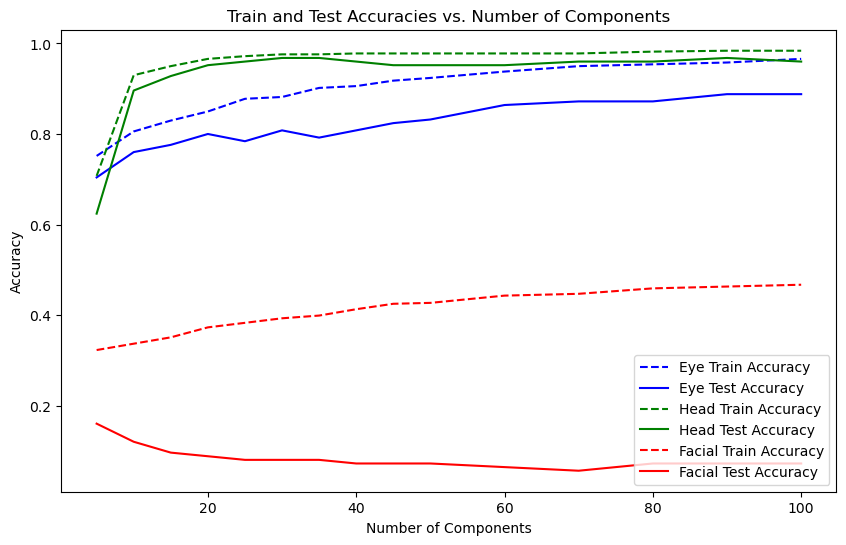

In [126]:
import matplotlib.pyplot as plt

n_components = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

# Plotting for all datasets on a single plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as per your preference

# Plotting for eye data
plt.plot(n_components, eye_train_pca_accuracies, 'b--', label='Eye Train Accuracy')
plt.plot(n_components, eye_test_pca_accuracies, 'b', label='Eye Test Accuracy')

# Plotting for head data
plt.plot(n_components, head_train_pca_accuracies, 'g--', label='Head Train Accuracy')
plt.plot(n_components, head_test_pca_accuracies, 'g', label='Head Test Accuracy')

# Plotting for facial data
plt.plot(n_components, facial_train_pca_accuracies, 'r--', label='Facial Train Accuracy')
plt.plot(n_components, facial_test_pca_accuracies, 'r', label='Facial Test Accuracy')

plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracies vs. Number of Components')
plt.legend()
plt.show()


(499, 5)